In [1]:
import os, random, re, math, json
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure


## DeepCrime

In [2]:
datasets = ["MNIST", "CIFAR", "REUTERS"]
algos = ["hebo", "random", "bohb"]
times = [10, 20, 50]
repair_files = ["mnist_conv.py", "cifar10_conv.py", "lenet.py", "reuters.py"]

In [3]:
subject_paths = []
for dataset in datasets:
    # Read results
    
    HPO_subjects_path = f"/home/hpo/results/{dataset}"

    _subject_paths = []
    for dir1 in os.listdir(HPO_subjects_path):
        dir1_path = os.path.join(HPO_subjects_path, dir1)
        _subject_paths.append([dir1_path, dir1.split("|")[1]])
    subject_paths += _subject_paths

# print(subject_paths)
# Read origin and repaired accuracies
HPO_DC_orig_acc_path = "/home/hpo/data/DC_orig_holdout_acc.txt"
orig_accs, _repaired = {}, {}
with open(HPO_DC_orig_acc_path, "r") as f:
    for line in f:
        pnum, acc = line.strip().split("|")

        if pnum in repair_files:
            if pnum not in _repaired:
                _repaired[pnum] = []
            _repaired[pnum].append(float(acc))
        else:
            if pnum not in orig_accs:
                orig_accs[pnum] = []
            orig_accs[pnum].append(float(acc))
    
    # for k, v in orig_accs.items():
    #     orig_accs[k] = [np.mean(v), np.std(v)]
    # for k, v in _repaired.items():
    #     _repaired[k] = [np.mean(v), np.std(v)]

repaired = {
    "MNIST": _repaired["mnist_conv.py"],
    "REUTERS": _repaired["reuters.py"],
    "CIFAR": _repaired["cifar10_conv.py"]
}

with open('/home/hpo/data/id_map.json', 'r') as f:
    id_map = json.load(f)


In [4]:
max_holdout_metrics = {}
for path, pnum in subject_paths:
    res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
    algo, time, repeat, top10 = res.groups()
    key = f"{pnum}|{algo}|{time}|{top10}"

    #
    if int(time) not in times or top10 == "0":
        continue
    if int(repeat) >= 10:
        continue
    #

    df = pd.read_csv(path)
    df = df.iloc[1:]
    df = df.reset_index(drop=True)

    if "mean_loss" in list(df.columns):
        holdout_metric = df.iloc[df["mean_loss"].idxmin()]["holdout_loss"]
        if math.isnan(holdout_metric) or holdout_metric > orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
    else:
        holdout_metric = df.iloc[df["mean_accuracy"].idxmax()]["holdout_acc"]
        if math.isnan(holdout_metric) or holdout_metric < orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
    
    if key not in max_holdout_metrics:
        max_holdout_metrics[key] = []
    max_holdout_metrics[key].append(holdout_metric)

In [5]:
at_results_path = "/home/hpo/results/AutoTrainer/at_results.csv"
at_budget_path = "/home/hpo/results/AutoTrainer/at_deepcrime_budget.csv"

df = pd.read_csv(at_results_path)
mutants_list = list(set(df["Mutant"]))
print(mutants_list)

df_budget = pd.read_csv(at_budget_path)
at_budget = {10: {}, 20: {}, 50: {}}

for index, row in df_budget.iterrows():
    mutant = row["Mutant"]
    time = row["Number of Times Budget"]
    max_budget_idx = eval(row["Indices to Consider"])
    max_budget_idx = len(max_budget_idx)
    at_budget[time][mutant] = max_budget_idx


['reuters_change_loss_function_mutated0_MP_hinge', 'reuters_change_learning_rate_mutated0_MP_False_1.0', 'reuters_add_weights_regularisation_mutated0_MP_l1_0', 'mnist_change_weights_initialisation_mutated0_MP_zeros_0', 'origin_59325381', 'reuters_change_optimisation_function_mutated0_MP_sgd', 'origin_31880720', 'reuters_change_weights_initialisation_mutated0_MP_ones_0', 'origin_41600519', 'reuters_change_activation_function_mutated0_MP_softsign_2', 'cifar10_change_activation_function_mutated0_MP_hard_sigmoid_2', 'origin_48385830', 'origin_56380303', 'origin_45442843', 'mnist_remove_activation_function_mutated0_MP_7', 'reuters_remove_activation_function_mutated0_MP_2', 'origin_50306988']


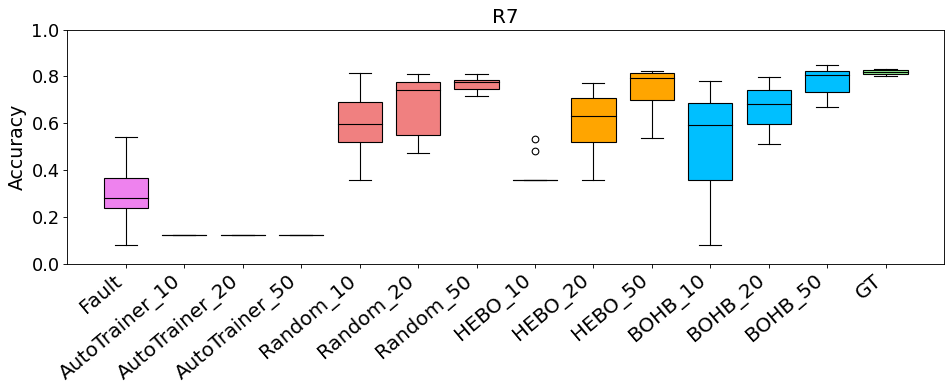

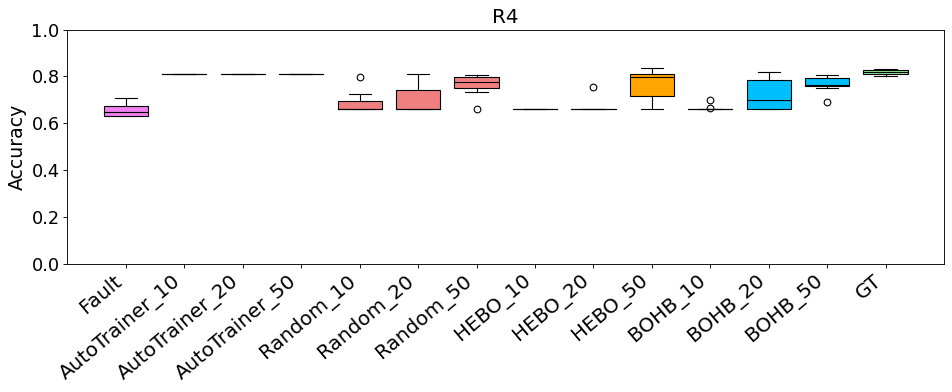

In [11]:
import matplotlib.patches as mpatches


def simulate(l, budget, mode="max"):
    rng = random.Random(42)
    r = []
    for _ in range(10):
        if budget == 0:
            r.append(0)
            continue
        
        _l = l.copy()
        rng.shuffle(_l)
        # print(len(_l), budget)
        if mode == "max":
            r.append(np.max(_l[:budget]))
        elif mode == "min":
            r.append(np.min(_l[:budget]))
    return r

for mutant in mutants_list:    
    if "origin" in mutant:
        continue
    ###############################
    if mutant not in ["reuters_change_loss_function_mutated0_MP_hinge",
                    "reuters_remove_activation_function_mutated0_MP_2"]:
        continue
    ###############################

    if "lenet" in mutant:
        dataset = "UNITY"
    elif "cifar10" in mutant:
        dataset = "CIFAR"
    elif "mnist" in mutant:
        dataset = "MNIST"
    elif "reuters" in mutant:
        dataset = "REUTERS"

    at_data = {10: {}, 20:{}, 50:{}}
    at_data[10][mutant] = simulate(list(df[df["Mutant"] == mutant]["MaxAccuracy"]), at_budget[10][mutant])
    at_data[20][mutant] = simulate(list(df[df["Mutant"] == mutant]["MaxAccuracy"]), at_budget[20][mutant])
    at_data[50][mutant] = simulate(list(df[df["Mutant"] == mutant]["MaxAccuracy"]), at_budget[50][mutant])
    # print(at_budget[10][mutant], at_budget[20][mutant], at_budget[50][mutant])

    hpo_data = {}
    for target_algo in ["random", "hebo", "bohb"]:
        _hpo_data = {10: {}, 20:{}, 50:{}}
            
        for k, v in max_holdout_metrics.items():
            _mutant, algo, limit, top10 = k.split("|")
            if algo != target_algo:
                continue
            if mutant == _mutant[:-3]:
                _hpo_data[int(limit)][mutant] = v

        hpo_data[target_algo] = _hpo_data
    
    # fig, ax = plt.subplots(figsize=(18, 5))
    figure(figsize=(12, 5), dpi=80)

    x = 0
    w = 0.33
    width = 0.25
    bp0 = plt.boxplot([orig_accs[mutant + ".py"]], positions=[x-w*4], widths=width, notch=False, vert=True, patch_artist=True)
    bp1_1 = plt.boxplot([at_data[10][mutant]], positions=[x-w*3], widths=width, notch=False, vert=True, patch_artist=True)
    bp1_2 = plt.boxplot([at_data[20][mutant]], positions=[x-w*2], widths=width, notch=False, vert=True, patch_artist=True)
    bp1_3 = plt.boxplot([at_data[50][mutant]], positions=[x-w], widths=width, notch=False, vert=True, patch_artist=True)
    bp2 = plt.boxplot([hpo_data["random"][10][mutant]], positions=[x], widths=width, notch=False, vert=True, patch_artist=True)
    bp3 = plt.boxplot([hpo_data["random"][20][mutant]], positions=[x+w], widths=width, notch=False, vert=True, patch_artist=True)
    bp4 = plt.boxplot([hpo_data["random"][50][mutant]], positions=[x+w*2], widths=width, notch=False, vert=True, patch_artist=True)
    bp5 = plt.boxplot([hpo_data["hebo"][10][mutant]], positions=[x+w*3], widths=width, notch=False, vert=True, patch_artist=True)
    bp6 = plt.boxplot([hpo_data["hebo"][20][mutant]], positions=[x+w*4], widths=width, notch=False, vert=True, patch_artist=True)
    bp7 = plt.boxplot([hpo_data["hebo"][50][mutant]], positions=[x+w*5], widths=width, notch=False, vert=True, patch_artist=True)
    bp8 = plt.boxplot([hpo_data["bohb"][10][mutant]], positions=[x+w*6], widths=width, notch=False, vert=True, patch_artist=True)
    bp9 = plt.boxplot([hpo_data["bohb"][20][mutant]], positions=[x+w*7], widths=width, notch=False, vert=True, patch_artist=True)
    bp10 = plt.boxplot([hpo_data["bohb"][50][mutant]], positions=[x+w*8], widths=width, notch=False, vert=True, patch_artist=True)
    bp11 = plt.boxplot([repaired[dataset]], positions=[x+w*9], widths=width, notch=False, vert=True, patch_artist=True)

    for patch in bp0['boxes']:
        patch.set_facecolor("violet")
    for median in bp0['medians']:
        median.set_color('black')
    for patch in bp1_1['boxes']:
        patch.set_facecolor("silver")
    for median in bp1_1['medians']:
        median.set_color('black')

    for patch in bp1_2['boxes']:
        patch.set_facecolor("silver")
    for median in bp1_2['medians']:
        median.set_color('black')
    for patch in bp1_3['boxes']:
        patch.set_facecolor("silver")
    for median in bp1_3['medians']:
        median.set_color('black')
    for patch in bp2['boxes']:
        patch.set_facecolor("lightcoral")
    for median in bp2['medians']:
        median.set_color('black')
    for patch in bp3['boxes']:
        patch.set_facecolor("lightcoral")
    for median in bp3['medians']:
        median.set_color('black')
    for patch in bp4['boxes']:
        patch.set_facecolor("lightcoral")
    for median in bp4['medians']:
        median.set_color('black')

    for patch in bp5['boxes']:
        patch.set_facecolor("orange")
    for median in bp5['medians']:
        median.set_color('black')
    for patch in bp6['boxes']:
        patch.set_facecolor("orange")
    for median in bp6['medians']:
        median.set_color('black')
    for patch in bp7['boxes']:
        patch.set_facecolor("orange")
    for median in bp7['medians']:
        median.set_color('black')

    for patch in bp8['boxes']:
        patch.set_facecolor("deepskyblue")
    for median in bp8['medians']:
        median.set_color('black')
    for patch in bp9['boxes']:
        patch.set_facecolor("deepskyblue")
    for median in bp9['medians']:
        median.set_color('black')
    for patch in bp10['boxes']:
        patch.set_facecolor("deepskyblue")
    for median in bp10['medians']:
        median.set_color('black')
    for patch in bp11['boxes']:
        patch.set_facecolor("lightgreen")
    for median in bp11['medians']:
        median.set_color('black')
    patch1 = mpatches.Patch(color="violet", label="Fault")
    patch2 = mpatches.Patch(color="silver", label="AutoTrainer")
    patch3 = mpatches.Patch(color="lightcoral", label="Random")
    patch4 = mpatches.Patch(color="orange", label="HEBO")
    patch5 = mpatches.Patch(color="deepskyblue", label="BOHB")
    patch6 = mpatches.Patch(color="lightgreen", label="GT")
    
    # plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc='lower right')

    xticks = [x-w*4, x-w*3, x-w*2, x-w]
    for _i in range(0, 10):
        xticks.append(x + w*_i)
    plt.xticks(xticks, ["Fault", "AutoTrainer_10", "AutoTrainer_20", "AutoTrainer_50",
    f"Random_10", f"Random_20", f"Random_50",
    f"HEBO_10", f"HEBO_20", f"HEBO_50",
    f"BOHB_10", f"BOHB_20", f"BOHB_50",
    "GT"], rotation=40, ha="right", fontsize=18)
    # ax.set_xticklabels(at_data.keys(), rotation=20, ha="right")
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

    plt.ylabel("Accuracy", fontsize=17)
    plt.xlim(xticks[0]-w, xticks[-1]+w)
    plt.title(id_map[mutant + ".py"], fontsize=18)
    # plt.title(f"AutoTrainer vs. HPO_{target_algo}", fontsize=18)
    plt.tight_layout()
    plt.savefig(f'/home/hpo/figures/example_{mutant}.pdf')
    plt.show()



## DFD

In [4]:
subject_list = [
    "31880720",
    "39217567",
    "41600519",
    "45442843",
    "48385830",
    "48594888",
    "50306988",
    "51181393",
    "56380303",
    "59325381"
]

subject_name_map = {
    "31880720": "D1",
    "39217567": "D2",
    "41600519": "D3",
    "45442843": "D4",
    "48385830": "D5",
    "48594888": "D6",
    "50306988": "D7",
    "51181393": "D8",
    "56380303": "D9",
    "59325381": "D10"
}

algos = ["hebo", "random", "bohb"]
times = [10, 20, 50]

In [5]:
def check_results_there(subject_paths):
    cnt = {}
    for path, pnum in subject_paths:
        if pnum not in cnt:
            cnt[pnum] = 0
        cnt[pnum] += 1
    print(cnt)

# Read results
HPO_subjects_path = "/home/hpo/results/DFD/"
subject_paths = []
for dir1 in os.listdir(HPO_subjects_path):
    dir1_path = os.path.join(HPO_subjects_path, dir1)
    if dir1.split("|")[1] in subject_list:
        subject_paths.append([dir1_path, dir1.split("|")[1]])
check_results_there(subject_paths)

# Read origin accuracies
HPO_DFD_orig_acc_path = "/home/hpo/data/DeepFD_orig_holdout_acc.txt"
orig_accs = {}
with open(HPO_DFD_orig_acc_path, "r") as f:
    for line in f:
        pnum, repair_acc = line.strip().split("|")
        if pnum not in orig_accs:
            orig_accs[pnum] = []
        orig_accs[pnum].append(float(repair_acc))

# Read repaired accuracies
HPO_DFD_repair_path = "/home/hpo/data/DeepFD_repair_holdout_acc.txt"
repaired = {}

with open(HPO_DFD_repair_path, "r") as f:
    for line in f:
        pnum, repair_acc = line.strip().split("|")
        if pnum not in repaired:
            repaired[pnum] = []
        repaired[pnum].append(float(repair_acc))


{'39217567': 135, '45442843': 91, '31880720': 135, '48594888': 90, '50306988': 90, '56380303': 90, '59325381': 90, '51181393': 90, '41600519': 135, '48385830': 90}


In [6]:
max_holdout_metrics = {}
for path, pnum in subject_paths:
    res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
    algo, time, repeat, top10 = res.groups()
    key = f"{pnum}|{algo}|{time}|{top10}"

    # if key != '31880720|hebo|50|1':
    #     continue
    #
    if int(time) not in times or top10 == "0":
        continue
    if int(repeat) >= 10:
        continue
    #

    df = pd.read_csv(path)
    df = df.iloc[1:]
    df = df.reset_index(drop=True)
    # print(key)
    # 44998910|random|10|1
    if "mean_loss" in list(df.columns):
        holdout_metric = df.iloc[df["mean_loss"].idxmin()]["holdout_loss"]
        if math.isnan(holdout_metric) or holdout_metric > orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
    else:
        holdout_metric = df.iloc[df["mean_accuracy"].idxmax()]["holdout_acc"]
        if math.isnan(holdout_metric) or holdout_metric < orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
    
    if key not in max_holdout_metrics:
        max_holdout_metrics[key] = []
    max_holdout_metrics[key].append(holdout_metric)

metrics = {}
for k in sorted(max_holdout_metrics):
    pnum, algo, time, top10 = k.split("|")
    time = int(time)

    if pnum not in metrics:
        metrics[pnum] = {}
        for _time in times:
            metrics[pnum][_time] = {}
            for _algo in algos:
                metrics[pnum][_time][_algo] = []
    # print(metrics)
    metrics[pnum][time][algo] = [np.mean(max_holdout_metrics[k]), np.std(max_holdout_metrics[k]), iqr(max_holdout_metrics[k])]

In [7]:
at_results_path = "/home/hpo/results/AutoTrainer/at_deepfd_results.csv"
at_budget_path = "/home/hpo/results/AutoTrainer/at_deepfd_budget.csv"

df = pd.read_csv(at_results_path)
mutants_list = list(set(df["Mutant"]))
print(mutants_list)

df_budget = pd.read_csv(at_budget_path)
at_budget = {10: {}, 20: {}, 50: {}}

for index, row in df_budget.iterrows():
    mutant = row["Mutant"]
    time = row["Number of Times Budget"]
    max_budget_idx = eval(row["Indices to Consider"])
    max_budget_idx = len(max_budget_idx)
    at_budget[time][mutant] = max_budget_idx


['origin_31880720', 'origin_45442843', 'origin_59325381', 'origin_50306988', 'origin_41600519', 'origin_56380303', 'origin_48385830']


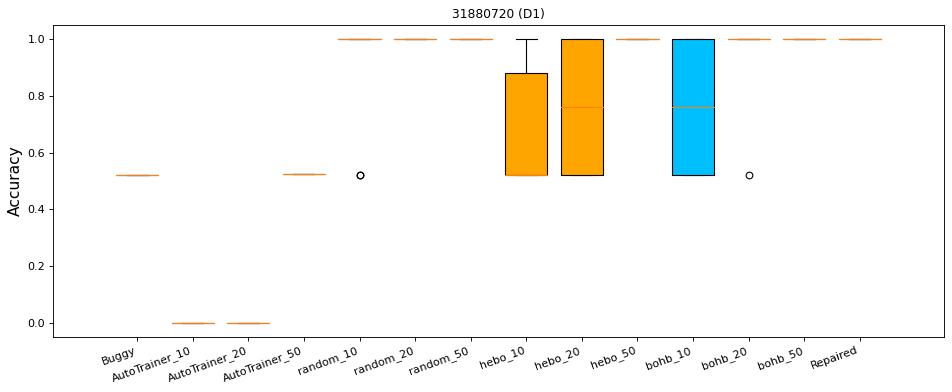

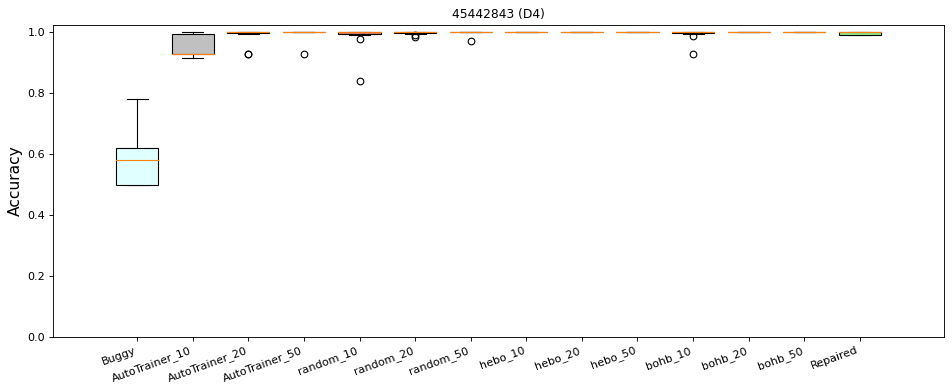

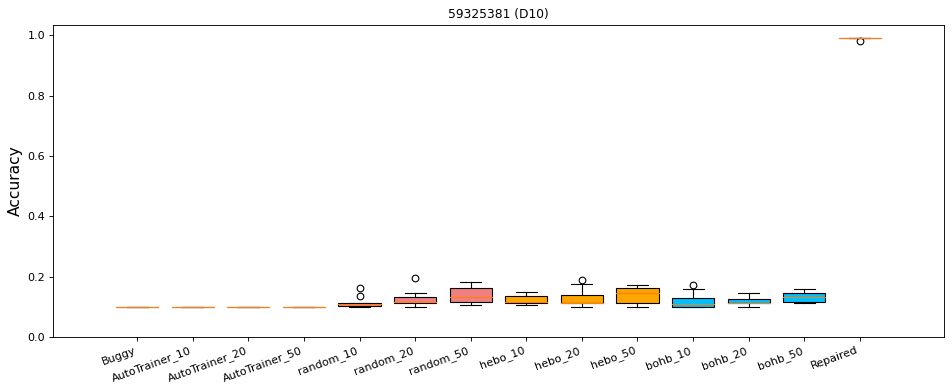

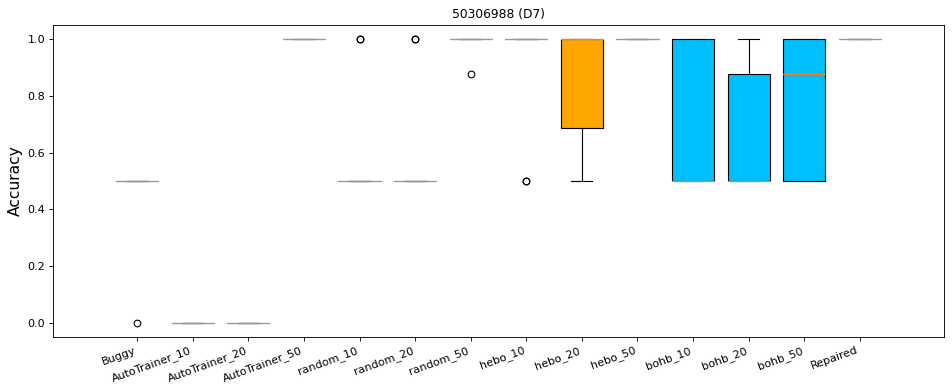

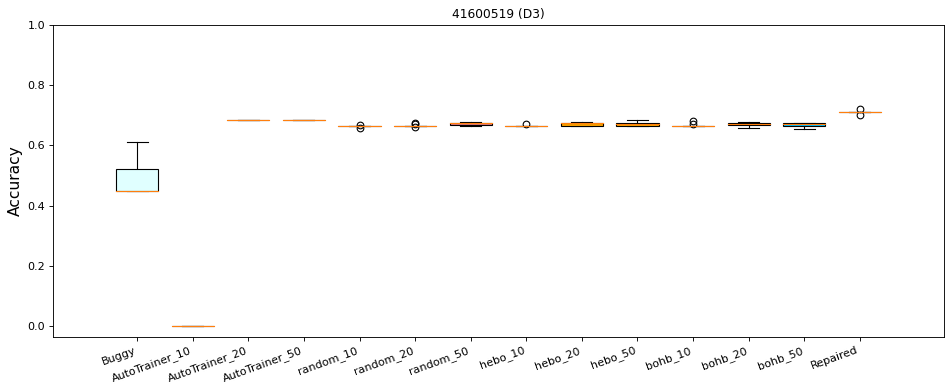

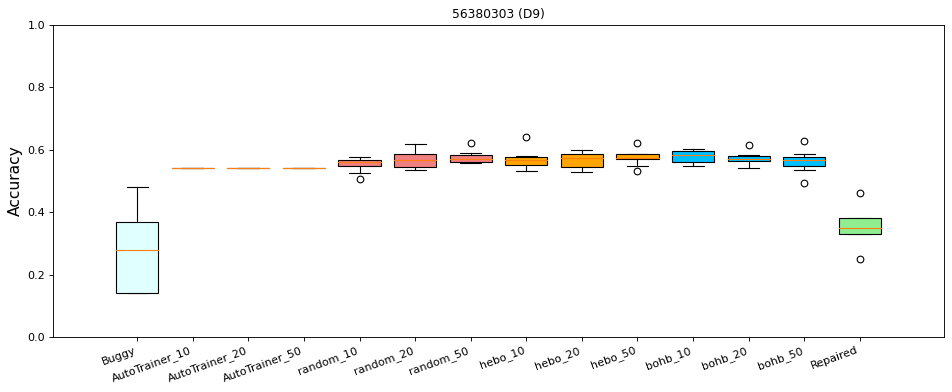

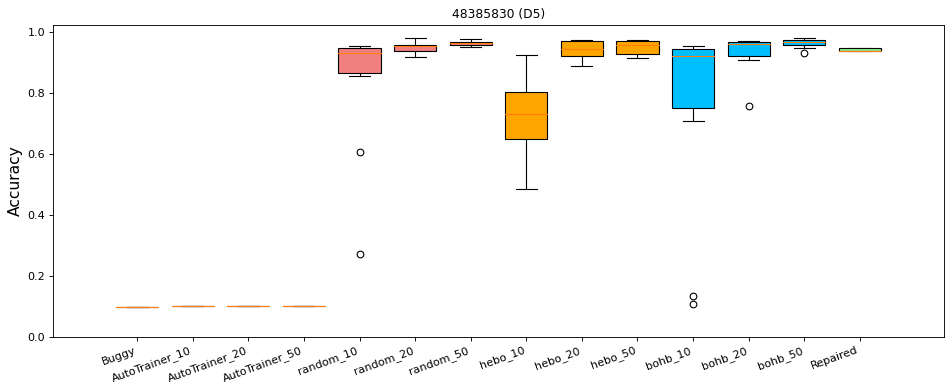

In [8]:
def simulate(l, budget, mode="max"):
    rng = random.Random(42)
    r = []
    for _ in range(10):
        if budget == 0:
            r.append(0)
            continue
        
        _l = l.copy()
        rng.shuffle(_l)
        # print(len(_l), budget)
        if mode == "max":
            r.append(np.max(_l[:budget]))
        elif mode == "min":
            r.append(np.min(_l[:budget]))
    return r

for mutant in mutants_list:

    at_data = {10: {}, 20:{}, 50:{}}
    at_data[10][mutant] = simulate(list(df[df["Mutant"] == mutant]["MaxAccuracy"]), at_budget[10][mutant])
    at_data[20][mutant] = simulate(list(df[df["Mutant"] == mutant]["MaxAccuracy"]), at_budget[20][mutant])
    at_data[50][mutant] = simulate(list(df[df["Mutant"] == mutant]["MaxAccuracy"]), at_budget[50][mutant])
    # print(at_budget[10][mutant], at_budget[20][mutant], at_budget[50][mutant])

    hpo_data = {}
    for target_algo in ["random", "hebo", "bohb"]:
        _hpo_data = {10: {}, 20:{}, 50:{}}
            
        for k, v in max_holdout_metrics.items():
            _mutant, algo, limit, top10 = k.split("|")
            if algo != target_algo:
                continue
            if mutant[7:] == _mutant:
                _hpo_data[int(limit)][mutant] = v

        hpo_data[target_algo] = _hpo_data

    # fig, ax = plt.subplots(figsize=(18, 5))
    figure(figsize=(12, 5), dpi=80)

    x = 0
    w = 0.33
    width = 0.25

    bp0 = plt.boxplot([orig_accs[mutant[7:]]], positions=[x-w*4], widths=width, notch=False, vert=True, patch_artist=True)
    bp1_1 = plt.boxplot([at_data[10][mutant]], positions=[x-w*3], widths=width, notch=False, vert=True, patch_artist=True)
    bp1_2 = plt.boxplot([at_data[20][mutant]], positions=[x-w*2], widths=width, notch=False, vert=True, patch_artist=True)
    bp1_3 = plt.boxplot([at_data[50][mutant]], positions=[x-w], widths=width, notch=False, vert=True, patch_artist=True)
    bp2 = plt.boxplot([hpo_data["random"][10][mutant]], positions=[x], widths=width, notch=False, vert=True, patch_artist=True)
    bp3 = plt.boxplot([hpo_data["random"][20][mutant]], positions=[x+w], widths=width, notch=False, vert=True, patch_artist=True)
    bp4 = plt.boxplot([hpo_data["random"][50][mutant]], positions=[x+w*2], widths=width, notch=False, vert=True, patch_artist=True)
    bp5 = plt.boxplot([hpo_data["hebo"][10][mutant]], positions=[x+w*3], widths=width, notch=False, vert=True, patch_artist=True)
    bp6 = plt.boxplot([hpo_data["hebo"][20][mutant]], positions=[x+w*4], widths=width, notch=False, vert=True, patch_artist=True)
    bp7 = plt.boxplot([hpo_data["hebo"][50][mutant]], positions=[x+w*5], widths=width, notch=False, vert=True, patch_artist=True)
    bp8 = plt.boxplot([hpo_data["bohb"][10][mutant]], positions=[x+w*6], widths=width, notch=False, vert=True, patch_artist=True)
    bp9 = plt.boxplot([hpo_data["bohb"][20][mutant]], positions=[x+w*7], widths=width, notch=False, vert=True, patch_artist=True)
    bp10 = plt.boxplot([hpo_data["bohb"][50][mutant]], positions=[x+w*8], widths=width, notch=False, vert=True, patch_artist=True)
    bp11 = plt.boxplot([repaired[mutant[7:]]], positions=[x+w*9], widths=width, notch=False, vert=True, patch_artist=True)

    for patch in bp0['boxes']:
        patch.set_facecolor("lightcyan")

    for patch in bp1_1['boxes']:
        patch.set_facecolor("silver")
    for patch in bp1_2['boxes']:
        patch.set_facecolor("silver")
    for patch in bp1_3['boxes']:
        patch.set_facecolor("silver")

    for patch in bp2['boxes']:
        patch.set_facecolor("lightcoral")
    for patch in bp3['boxes']:
        patch.set_facecolor("lightcoral")
    for patch in bp4['boxes']:
        patch.set_facecolor("lightcoral")

    for patch in bp5['boxes']:
        patch.set_facecolor("orange")
    for patch in bp6['boxes']:
        patch.set_facecolor("orange")
    for patch in bp7['boxes']:
        patch.set_facecolor("orange")

    for patch in bp8['boxes']:
        patch.set_facecolor("deepskyblue")
    for patch in bp9['boxes']:
        patch.set_facecolor("deepskyblue")
    for patch in bp10['boxes']:
        patch.set_facecolor("deepskyblue")
    for patch in bp11['boxes']:
        patch.set_facecolor("lightgreen")

    # patch1 = mpatches.Patch(color=colors[0], label="AutoTrainer")
    # patch2 = mpatches.Patch(color=colors[1], label=f"{target_algo}_10")
    # patch3 = mpatches.Patch(color=colors[2], label=f"{target_algo}_20")
    # patch4 = mpatches.Patch(color=colors[3], label=f"{target_algo}_50")
    # plt.legend(handles=[patch1, patch2, patch3, patch4], loc='lower right')
    xticks = [x-w*4, x-w*3, x-w*2, x-w]
    for _i in range(0, 10):
        xticks.append(x + w*_i)
    plt.xticks(xticks, ["Buggy", "AutoTrainer_10", "AutoTrainer_20", "AutoTrainer_50",
    f"random_10", f"random_20", f"random_50",
    f"hebo_10", f"hebo_20", f"hebo_50",
    f"bohb_10", f"bohb_20", f"bohb_50",
    "Repaired"], rotation=20, ha="right")
    # ax.set_xticklabels(at_data.keys(), rotation=20, ha="right")
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    plt.ylabel("Accuracy", fontsize=14)
    plt.title(f"{mutant[7:]} ({subject_name_map[mutant[7:]]})", fontsize=11)
    # plt.title(f"AutoTrainer vs. HPO_{target_algo}", fontsize=18)
    plt.tight_layout()
    plt.show()

